In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

from pideq.deq.solvers import forward_iteration
from pideq.deq.model import DEQ

# Target definition

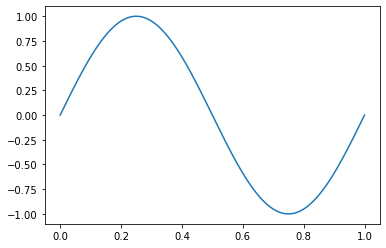

In [3]:
f_real = lambda t: np.sin(t*2*np.pi)

X = np.linspace(0, 1, 1000)
y = f_real(X)
plt.plot(X, y)
plt.show()

X = torch.Tensor(X).unsqueeze(-1)
y = torch.Tensor(y).unsqueeze(-1)

# Training

  0%|          | 0/1000 [00:00<?, ?it/s]

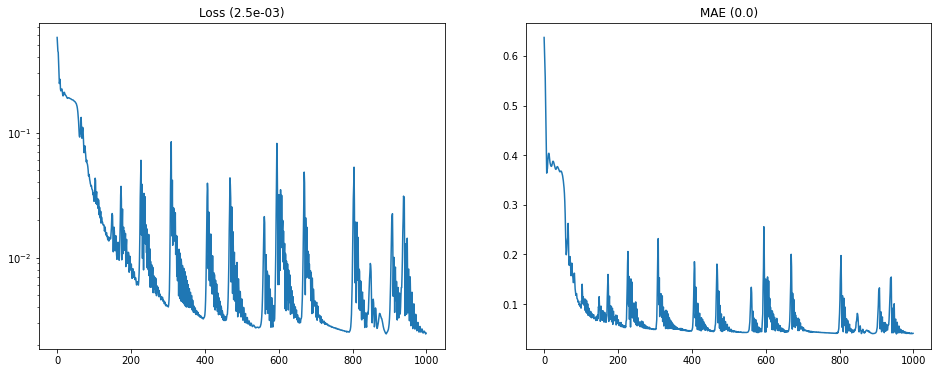

CPU times: user 17.2 s, sys: 531 ms, total: 17.7 s
Wall time: 9.89 s


In [4]:
%%time
n_in = 1
n_out = 1
n_states = 5
deq = DEQ(n_in, n_out, n_states)

loss_f = nn.MSELoss()
# optimizer = optim.SGD(deq.parameters(), lr=0.1, momentum=0.99)
optimizer = optim.Adam(deq.parameters(), lr=0.1)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

maes = list()
losses = list()
y_preds = list()

X.requires_grad_()
for e in tqdm(list(range(1000))):
    deq.train()
    optimizer.zero_grad()

    y_pred, jac_loss = deq(X)

    loss = loss_f(y_pred, y) + jac_loss

    loss.backward()
    optimizer.step()
#     scheduler.step()
#     scheduler.step(loss.item())

    losses.append(loss.item())
    y_preds.append(y_pred.detach().numpy())
    maes.append(
        (y_pred - y).abs().mean().detach().numpy()
    )
    if np.isnan(losses[-1]):
        break

fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,6)

axs[0].semilogy(losses)
axs[0].set_title(f"Loss ({losses[-1]:.1e})")

axs[1].plot(maes)
axs[1].set_title(f"MAE ({maes[-1]:.1f})")

plt.show()

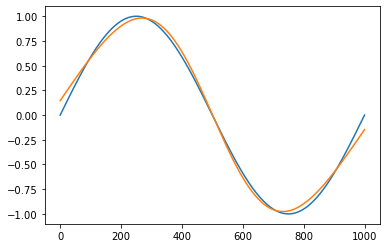

In [5]:
plt.plot(y.numpy())
plt.plot(y_preds[np.argmin(maes)])

/tmp/ipykernel_15099/3211288142.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


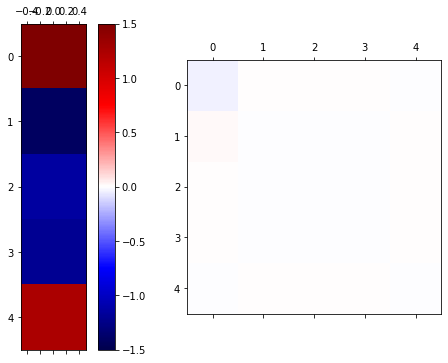

In [7]:
fig, axs = plt.subplots(1,2)

fig.set_size_inches(10,6)

p = axs[0].matshow(deq.A.detach().cpu().numpy(), cmap='seismic', vmin=-1.5, vmax=1.5)
fig.colorbar(p, ax=axs[0])

axs[1].matshow(deq.B.detach().cpu().numpy(), cmap='seismic', vmin=-1.5, vmax=1.5)

fig.show()